In [108]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import cv2 as cv
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
import nltk
from matplotlib import pyplot as plt
from textblob import TextBlob 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datetime import date
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import requests
import matplotlib.pyplot as plt

In [109]:
polarity_mapping = {"Extremely Negative": -2,
                    "Negative": -1,
                    "Neutral": 0,
                    "Positive": 1,
                    "Extremely Positive": 2};

inv_polarity_mapping = {-2: "Extremely Negative",
                        -1: "Negative",
                        0: "Neutral",
                        1: "Positive",
                        2: "Extremely Positive"}

data_sentiments = []

sentiments = ["Extremely Negative",  "Negative", "Neutral", "Positive", "Extremely Positive"];

hashtags = [];

count = 0;
sentiment_search = "";

train_features = [];
train_labels = [];

negative_data = [];
neutral_data = [];
positive_data = [];

analyzer = SentimentIntensityAnalyzer()

In [110]:
def remove_ats_and_links(row):
    text = row["OriginalTweet"];
    text = text.split();

    new_text = "";

    for word in text:
        
        all_ascii = True

        for letter in word:
            if(letter.isascii() == False):
                all_ascii = False;
                break;

        if(word[0] == '@' or ("http" in word) or not all_ascii): continue;

        new_text += word + " ";
    row["EditiedTweet"] = new_text;
    return row;

def process_hashtags(row):
    text = row["EditiedTweet"].split();
    new_text = ""

    for word in text:
        if(word[0] == '#'):
            hashtags.append(word[1:]);
            continue
        new_text += word + " ";
    row["EditiedTweet"] = new_text;
    return row;

def make_features_and_labels(row):
    text = row["EditiedTweet"];
    sentiment = analyzer.polarity_scores(text);
    try:
        train_labels.append(polarity_mapping[row["Sentiment"]]);
    
        if("Negative" in row["Sentiment"]):
            negative_data.append(sentiment['neg']);
            negative_data.append(sentiment['neu']);
            negative_data.append(sentiment['pos']);
            #negative_data.append(sentiment['compound']);
        if("Neutral" in row["Sentiment"]):
            neutral_data.append(sentiment['neg']);
            neutral_data.append(sentiment['neu']);
            neutral_data.append(sentiment['pos']);
            #neutral_data.append(sentiment['compound']);
        if("Positive" in row["Sentiment"]):
            positive_data.append(sentiment['neg']);
            positive_data.append(sentiment['neu']);
            positive_data.append(sentiment['pos']);
            #positive_data.append(sentiment['compound']);

    except KeyError:
        pass;
    train_features.append(sentiment['neg']);
    train_features.append(sentiment['neu']);
    train_features.append(sentiment['pos']);
    #train_features.append(sentiment['compound']);
    
    return row


In [111]:

train = pd.read_csv("Pandemic_NLP_train.csv");
test = pd.read_csv("Pandemic_NLP_test_.csv");

#train = train.head(1000);

In [112]:
display(train);
#display(test);

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know it's getting tough when @KameronWilds...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [113]:
train = train.apply(remove_ats_and_links, axis=1);
train = train.apply(process_hashtags, axis=1);
train = train.apply(make_features_and_labels, axis=1);

In [114]:
display(train);

print(negative_data)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,EditiedTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the outb..."
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,Airline pilots offering to stock supermarket s...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,Response to complaint not provided citing COVI...
41154,44953,89905,NaN,14-04-2020,You know it's getting tough when @KameronWilds...,Positive,You know it's getting tough when is rationing ...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,Is it wrong that the smell of hand sanitizer i...


[0.093, 0.662, 0.245, 0.112, 0.888, 0.0, 0.184, 0.778, 0.038, 0.194, 0.662, 0.143, 0.193, 0.807, 0.0, 0.229, 0.701, 0.07, 0.124, 0.876, 0.0, 0.202, 0.798, 0.0, 0.087, 0.913, 0.0, 0.142, 0.819, 0.039, 0.073, 0.867, 0.06, 0.425, 0.575, 0.0, 0.231, 0.769, 0.0, 0.311, 0.689, 0.0, 0.138, 0.862, 0.0, 0.168, 0.785, 0.047, 0.249, 0.703, 0.048, 0.318, 0.455, 0.227, 0.344, 0.656, 0.0, 0.159, 0.78, 0.061, 0.19, 0.737, 0.073, 0.169, 0.79, 0.04, 0.091, 0.909, 0.0, 0.172, 0.828, 0.0, 0.214, 0.672, 0.114, 0.145, 0.855, 0.0, 0.28, 0.645, 0.075, 0.108, 0.892, 0.0, 0.173, 0.731, 0.096, 0.117, 0.883, 0.0, 0.156, 0.792, 0.053, 0.118, 0.799, 0.083, 0.286, 0.714, 0.0, 0.075, 0.871, 0.054, 0.189, 0.706, 0.105, 0.291, 0.709, 0.0, 0.076, 0.924, 0.0, 0.276, 0.724, 0.0, 0.191, 0.809, 0.0, 0.072, 0.928, 0.0, 0.281, 0.719, 0.0, 0.11, 0.81, 0.081, 0.321, 0.617, 0.062, 0.172, 0.828, 0.0, 0.188, 0.812, 0.0, 0.13, 0.776, 0.095, 0.173, 0.739, 0.088, 0.268, 0.558, 0.174, 0.138, 0.804, 0.058, 0.192, 0.664, 0.143, 0.116, 

In [115]:
train_features = np.array(train_features).reshape(-1, 3);
train_labels = np.array(train_labels);

In [116]:
negative_data = np.array(negative_data).reshape(-1, 3);
neutral_data = np.array(neutral_data).reshape(-1, 3);
positive_data = np.array(positive_data).reshape(-1, 3);

print(negative_data)

[[0.093 0.662 0.245]
 [0.112 0.888 0.   ]
 [0.184 0.778 0.038]
 ...
 [0.086 0.865 0.049]
 [0.206 0.794 0.   ]
 [0.119 0.803 0.078]]


In [117]:
pca = PCA(n_components=2)
pca_results_negative = pca.fit_transform(negative_data)
pca_results_neutral = pca.fit_transform(neutral_data)
pca_results_positive = pca.fit_transform(positive_data)

In [118]:
print(pca_results_negative);

[[-0.0566674   0.24313709]
 [ 0.13465171 -0.03046537]
 [ 0.00028021 -0.00453714]
 ...
 [ 0.12740029  0.02914497]
 [ 0.00333792 -0.05117013]
 [ 0.05551311  0.05376651]]


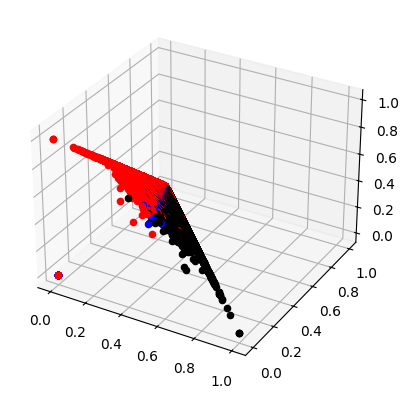

In [119]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')



for x, y, z in negative_data:
    ax.scatter(x, y, z, '^', c='k');
for x, y, z in neutral_data:
    ax.scatter(x, y, z, '^', c='b');
for x, y, z in positive_data:
    ax.scatter(x, y, z, 'r^', c='r');


#ax.scatter(negative_data);
#ax.scatter(positive_data);
#ax.scatter(neutral_data);
#plt.plot(neutral_data, 'b.', 0.1);
#plt.plot(positive_data, 'r.', 0.1);
plt.show();


In [120]:
print(train_features)
print(train_labels)

[[0.    1.    0.   ]
 [0.    0.923 0.077]
 [0.    0.8   0.2  ]
 ...
 [0.089 0.715 0.196]
 [0.161 0.674 0.166]
 [0.119 0.803 0.078]]
[ 0  1  1 ...  1  0 -1]


In [121]:
model = MLPClassifier(verbose=True, max_iter=100000, tol=0.0001, learning_rate='adaptive').fit(train_features, train_labels);

Iteration 1, loss = 1.44904836
Iteration 2, loss = 1.08123797
Iteration 3, loss = 0.87271740
Iteration 4, loss = 0.78692694
Iteration 5, loss = 0.74519697
Iteration 6, loss = 0.72023685
Iteration 7, loss = 0.70306245
Iteration 8, loss = 0.68964794
Iteration 9, loss = 0.67939763
Iteration 10, loss = 0.67073039
Iteration 11, loss = 0.66369582
Iteration 12, loss = 0.65783585
Iteration 13, loss = 0.65263496
Iteration 14, loss = 0.64839729
Iteration 15, loss = 0.64497587
Iteration 16, loss = 0.64191416
Iteration 17, loss = 0.63921203
Iteration 18, loss = 0.63684808
Iteration 19, loss = 0.63461985
Iteration 20, loss = 0.63278782
Iteration 21, loss = 0.63116030
Iteration 22, loss = 0.62944238
Iteration 23, loss = 0.62807323
Iteration 24, loss = 0.62668754
Iteration 25, loss = 0.62516098
Iteration 26, loss = 0.62404332
Iteration 27, loss = 0.62298339
Iteration 28, loss = 0.62149839
Iteration 29, loss = 0.62043283
Iteration 30, loss = 0.61951804
Iteration 31, loss = 0.61816383
Iteration 32, los

In [122]:
print(analyzer.polarity_scores("test"))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [123]:
train_features = [];
train_labels = [];

In [124]:
test = test.apply(remove_ats_and_links, axis=1);
test = test.apply(process_hashtags, axis=1);
tset = test.apply(make_features_and_labels, axis=1);

In [125]:
train_features = np.array(train_features).reshape(-1, 3);
train_labels = np.array(train_labels);

test_features = train_features;
test_labels = train_labels;

In [126]:
ans = model.predict(test_features);
ans_string = [];

In [127]:
for i in range(len(ans)):
    ans_string.append(inv_polarity_mapping[ans[i]]);


In [128]:
df_ans = pd.DataFrame();

df_ans["OriginalTweet"] = test["OriginalTweet"];
df_ans["Sentiment"] = ans_string;

df_ans.to_csv("ans.csv", index=False);

display(df_ans);

,OriginalTweet,Sentiment
0,COVID-19 might be presenting online shopping p...,Extremely Positive
1,My right wing coo coo father in law was tellin...,Negative
2,I cannot decide if I am the smartest person in...,Positive
3,Why are people stock piling what s wrong wit...,Extremely Negative
4,Show me where the eggs are. That's all I need ...,Neutral
...,...,...
3793,You can tell this episode of Here's Lucy is fr...,Extremely Positive
3794,"You can watch my 11-minute video on ""Tiny Habi...",Positive
3795,"You know, normally I don't tweet but I am low-...",Positive
3796,You would have thought that with everyone so w...,Extremely Negative
